In [13]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [14]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph-Use-Case")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph-Use-Case]


## 에이전트 대화 시뮬레이션(고객 응대 시나리오)

챗봇 개발 후에 챗봇이 원활하게 동작하는지 검증이 필요할때 자가테스트 및 시나리오 테스트 할 때 사용하는 가상의 유저입니다.  
  
가상의 유저에게 조건들을 주고 상황을 만들어 에이전트 스스로 대화를 시켜서 모니터링합니다.  

##### 그래프 흐름

![langgraph_use_case_agent_simulation](./assets/langgraph_use_case_agent_simulation.png)

#### 상담사, 고객 역할 정의

##### 상담사 역할 정의

시뮬레이션에서 상담사 역할을 하는 챗봇을 정의합니다. 

In [36]:
from typing import List
from models import LLMs, get_model_name
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser

MODEL_NAME = get_model_name(LLMs.GPT4o_MINI)


def call_chatbot(messages: List[BaseMessage]) -> dict:
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a customer support agent for an airline. Answer in Korean.",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    model = ChatOpenAI(model=MODEL_NAME, temperature=0)
    chain = prompt | model | StrOutputParser()
    return chain.invoke({"messages": messages})

In [37]:
call_chatbot([("user", "안녕하세요?")])

'안녕하세요! 어떻게 도와드릴까요?'

##### 고객 역할(Simulated User) 정의

시뮬레이션에서 고객의 역할을 정의합니다. 고객 지원 시나리오에서의 대화를 시뮬레이션합니다.  
  
시스템 프롬프트에는 고객과 고객 지원 담당자 간의 상호작용을 설정하며, 사용자 지시사항을 통해 시나리오의 세부 사항을 제공합니다.  
  
특정 상황에 대한 모델 반을을 시뮬레이션합니다.

In [38]:
def create_scenario(name: str, instructions: str):
    # 시스템 프롬프트 정의
    system_prompt_template = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person. \

Your name is {name}.

# Instructions:
{instructions}

[IMPORTANT] 
- When you are finished with the conversation, respond with a single word 'FINISHED'
- You must speak in Korean."""

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt_template),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    prompt = prompt.partial(name=name, instructions=instructions)
    return prompt

환불을 요청하는가상의 시나리오를 생성합니다.

In [39]:
# 사용자 지시사항을 정의합니다.
instructions = """You are trying to get a refund for the trip you took to Jeju Island. \
You want them to give you ALL the money back. This trip happened last year."""

# 사용자 이름을 정의합니다.
name = "June"

create_scenario(name, instructions).pretty_print()

================================ System Message ================================

You are a customer of an airline company. You are interacting with a user who is a customer support person. 
Your name is {name}.

# Instructions:
{instructions}

[IMPORTANT] 
- When you are finished with the conversation, respond with a single word 'FINISHED'
- You must speak in Korean.

============================= Messages Placeholder =============================

{messages}


In [40]:
model = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 시뮬레이션된 사용자 생성
simulated_user = (
    create_scenario(name=name, instructions=instructions) | model | StrOutputParser()
)

In [41]:
from langchain_core.messages import HumanMessage

# 시뮬레이션된 사용자에게 메시지를 전달(상담사 -> 고객)
messages = [HumanMessage(content="안녕하세요? 어떻게 도와 드릴까요?")]
simulated_user.invoke({"messages": messages})

'안녕하세요. 저는 작년에 제주도로 여행을 갔었는데, 그 여행에 대한 전액 환불을 요청하고 싶습니다. 어떻게 진행해야 할까요?'

#### 1. 상태정의

In [42]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


# State 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

#### 2. 노드 정의

In [43]:
from langchain_core.messages import AIMessage


# 상담사 역할
def ai_assistant_node(messages):
    # 상담사 응답 호출
    ai_response = call_chatbot(messages)

    # AI 상담사의 응답을 반환
    return {"messages": [("assistant", ai_response)]}

In [44]:
ai_assistant_node(
    [
        ("user", "안녕하세요?"),
        ("assistant", "안녕하세요! 어떻게 도와드릴까요?"),
        ("user", "환불 어떻게 하나요?"),
    ]
)

{'messages': [('assistant',
   '환불 절차는 다음과 같습니다:\n\n1. **예약 확인**: 예약 번호와 함께 예약 내용을 확인합니다.\n2. **환불 요청**: 고객 서비스 센터에 연락하시거나, 웹사이트의 환불 요청 양식을 작성해 주십시오.\n3. **필요 서류 제출**: 환불 요청 시 필요한 서류(예: 항공권, 신분증 등)를 제출해야 할 수 있습니다.\n4. **환불 처리**: 요청이 승인되면, 환불이 처리됩니다. 이 과정은 보통 몇 일에서 몇 주가 소요될 수 있습니다.\n\n더 궁금한 점이 있으시면 말씀해 주세요!')]}

In [45]:
def _swap_roles(messages):
    # 메시지의 역할을 교환: 시뮬레이션 사용자 단계에서 메시지 타입을 AI -> Human, Human -> AI 로 교환합니다.
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            # AIMessage 인 경우, HumanMessage 로 변환합니다.
            new_messages.append(HumanMessage(content=m.content))
        else:
            # HumanMessage 인 경우, AIMessage 로 변환합니다.
            new_messages.append(AIMessage(content=m.content))
    return new_messages


# 상담사 역할(AI Assistant) 노드 정의
def ai_assistant_node(state: State):
    # 상담사 응답 호출
    ai_response = call_chatbot(state["messages"])

    # AI 상담사의 응답을 반환
    return {"messages": [("assistant", ai_response)]}


# 시뮬레이션된 사용자(Simulated User) 노드 정의
def simulated_user_node(state: State):
    # 메시지 타입을 교환: AI -> Human, Human -> AI
    new_messages = _swap_roles(state["messages"])

    # 시뮬레이션된 사용자를 호출
    response = simulated_user.invoke({"messages": new_messages})
    return {"messages": [("user", response)]}


# 종료 노드
def should_continue(state: State):
    # 메시지 리스트의 길이가 6보다 크면 'end'를 반환합니다.
    if len(state["messages"]) > 6:
        return "end"
    # 마지막 메시지의 내용이 'FINISHED'라면 'end'를 반환합니다.
    elif state["messages"][-1].content == "FINISHED":
        return "end"
    # 위의 조건에 해당하지 않으면 'continue'를 반환합니다.
    else:
        return "continue"

#### 3. 엣지 정의 및 그래프 컴파일

In [46]:
from langgraph.graph import END, StateGraph

# StateGraph 인스턴스 생성
graph_builder = StateGraph(State)

# 노드 정의
graph_builder.add_node("simulated_user", simulated_user_node)
graph_builder.add_node("ai_assistant", ai_assistant_node)

# 엣지 정의 (챗봇 -> 시뮬레이션된 사용자)
graph_builder.add_edge("ai_assistant", "simulated_user")

# 조건부 엣지 정의
graph_builder.add_conditional_edges(
    "simulated_user",
    should_continue,
    {
        "end": END,  # 종료 조건이 충족되면 시뮬레이션을 중단
        "continue": "ai_assistant",  # 종료 조건이 충족되지 않으면 상담사 역할 노드로 메시지를 전달
    },
)

# 시작점 설정
graph_builder.set_entry_point("ai_assistant")

# 그래프 컴파일
simulation = graph_builder.compile()

#### 4. 그래프 시각화

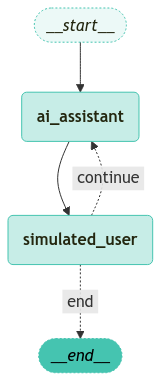

In [47]:
from graphs import visualize_graph

visualize_graph(simulation)

#### 5. 시뮬레이션

In [48]:
from langchain_core.runnables import RunnableConfig
from langchain_print import stream_graph, random_uuid


# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 입력 메시지 설정
inputs = {
    "messages": [HumanMessage(content="안녕하세요? 저 지금 좀 화가 많이 났습니다^^")]
}

# 그래프 스트리밍
stream_graph(simulation, inputs, config, node_names=["simulated_user", "ai_assistant"])


🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요! 고객님, 불편을 드려서 정말 죄송합니다. 어떤 문제로 화가 나셨는지 말씀해 주시면, 최선을 다해 도와드리겠습니다.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
작년 제주도 여행에 대한 환불을 요청하고 싶습니다. 모든 돈을 돌려받고 싶어요.
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
고객님, 제주도 여행에 대한 환불 요청을 도와드리겠습니다. 환불 절차는 예약하신 방법에 따라 다를 수 있습니다. 예약 번호와 함께 어떤 이유로 환불을 원하시는지 알려주시면, 보다 정확한 안내를 드릴 수 있습니다. 추가로 필요한 정보가 있으시면 말씀해 주세요.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
예약 번호는 123456입니다. 환불을 원하는 이유는 여러 가지 문제가 있었기 때문입니다. 여행이 기대했던 것과 너무 달라서 정말 실망했어요. 그래서 모든 돈을 돌려받고 싶습니다.
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
고객님, 예약 번호 123456으로 확인해 보겠습니다. 여행에 대한 기대와 달리 실망하셨다니 정말 안타깝습니다. 환불 요청을 처리하기 위해서는 고객님의 경험에 대한 자세한 내용을 확인해야 합니다. 

환불 요청은 일반적으로 여행사나 항공사 정책에 따라 다르게 처리될 수 있습니다. 고객님의 상황을 최대한 반영하여 처리할 수 있도록 하겠습니다. 

환불 요청을 위해 필요한 서류나 추가 정보가 있을 수 있으니, 고객님의 연락처를 남겨주시면 저희가 직접 연락드리겠습니다. 다